# Introduction


In this assignment, you will practice building and training Convolutional Neural Networks with Pytorch to solve computer vision tasks.  This assignment includes two sections, each involving different tasks:

(1) Image Classification. Predict image-level category labels on two historically notable image datasets: **CIFAR-10** and **MNIST**.

(2) Image Segmentation. Predict pixel-wise classification (semantic segmentation) on synthetic input images formed by superimposing MNIST images on top of CIFAR images.

You will design your own models in each section and build the entire training/testing pipeline with PyTorch. 
PyTorch provides optimized implementations of the building blocks and additional utilities, both of which will be necessary for experiments on real datasets. It is highly recommended to read the official [documentation](https://pytorch.org/docs/stable/index.html) and [examples](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) before starting your implementation. There are some APIs that you'll find useful:
[Layers](http://pytorch.org/docs/stable/nn.html),
[Activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity),
[Loss functions](http://pytorch.org/docs/stable/nn.html#loss-functions),
[Optimizers](http://pytorch.org/docs/stable/optim.html)

It is highly recommended to use Google Colab and run the notebook on a GPU node. Check https://colab.research.google.com/ and look for tutorials online. To use a GPU go to Runtime -> Change runtime type and select GPU. 






# (1) Image Classification

In this section, you will design and train an image classification network, which takes images as input and outputs vectors whose length equals the number of possible categories on **MNIST** and **CIFAR-10** datasets. 

You can design your models by borrowing ideas from recent architectures, e.g., ResNet, but you may not simply copy an entire existing model. 

For image classification, you can use a built-in dataset provided by [torchvision](https://pytorch.org/vision/stable/index.html), a PyTorch official extension for image tasks. 

To finish this section step by step, you need to:

* Prepare data by building a dataset and dataloader. (with [torchvision](https://pytorch.org/vision/stable/index.html))

* Implement training code (6 points) & testing code (6 points), including model saving and loading.

* Construct a model (12 points) and choose an optimizer (3 points).

* Describe what you did, any additional features you implemented, and/or any graphs you made in training and evaluating your network. Also report final test accuracy @100 epochs in a writeup: hw3.pdf (3 points)

In [7]:
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision
import torchvision.transforms as T


## Data Preparation:

Setup a Dataset for training and testing.

Datasets load single training examples one a time, so we practically wrap each Dataset in a DataLoader, which loads a data batch in parallel.

We provide an example for setting up a training set for MNIST, and you should complete the rest. 

In [8]:
mnist_train = torchvision.datasets.MNIST('./data', train = True, transform = T.ToTensor(),download = True)
data_loader = torch.utils.data.DataLoader(mnist_train,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=2)
##########################################################################
# TODO: YOUR CODE HERE
# (1) Instantiate the train/test split for CIFAR-10 and MNIST
# (2) You can adjust the batch size and number of works for better efficiency
# (3) Remember to set shuffle=True for all training set 
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cifar10_train = torchvision.datasets.CIFAR10('./data', train=True, transform=T.ToTensor(), download=True)
cifar10_train_subset = torch.utils.data.Subset(cifar10_train, range(1000))
cifar10_test = torchvision.datasets.CIFAR10('./data', train=False, transform=T.ToTensor(), download=True)
cifar10_test_subset = torch.utils.data.Subset(cifar10_test, range(1000))

cifar10_loader_train = torch.utils.data.DataLoader(cifar10_train, batch_size=32, shuffle=True, num_workers=2)
cifar10_loader_test = torch.utils.data.DataLoader(cifar10_test, batch_size=32, shuffle=False, num_workers=2)

mnist_train = torchvision.datasets.MNIST('./data', train=True, transform=T.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST('./data', train=False, transform=T.ToTensor(), download=True)

mnist_loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True, num_workers=2)
mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=32, shuffle=False, num_workers=2)
##########################################################################

Files already downloaded and verified
Files already downloaded and verified


## Design/choose your own model structure (12 points) and optimizer (3 points).
You might want to adjust the following configurations for better performance:

(1) Network architecture:
- You can borrow some ideas from existing CNN designs, e.g., ResNet where
the input from the previous layer is added to the output
https://arxiv.org/abs/1512.03385
- Note: Do not **directly copy** an entire existing network design.

(2) Architecture hyperparameters:
- Filter size, number of filters, and number of layers (depth). Make careful choices to tradeoff computational efficiency and accuracy.
- Pooling vs. Strided Convolution
- Batch normalization
- Choice of non-linear activation

(3) Choice of optimizer (e.g., SGD, Adam, Adagrad, RMSprop) and associated hyperparameters (e.g., learning rate, momentum).

In [9]:
#Basic model, feel free to customize the layout to fit your model design.

##########################################################################
# TODO: YOUR CODE HERE
# (1) Design the model for MNIST
class MNIST_models(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
    self.bn3 = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(3, 3)
    self.fc1 = nn.Linear(256, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

    #to improve add convolution layers

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    # print("1")
    # print("1", x.shape)
    # print(x.shape)
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    # print("2")
    # print("2", x.shape)
    # print(x.shape)
    x = self.pool(F.relu(self.bn3(self.conv3(x))))
    # print("3", x.shape)
    # print()
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
# (2) Design the model for CIFAR-10
class CIFAR10_models(nn.Module):
    def __init__(self):
      super().__init__()
      # Set up your own CNN.
      self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
      self.bn1 = nn.BatchNorm2d(16)
      self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
      self.bn2 = nn.BatchNorm2d(32)
      self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
      self.bn3 = nn.BatchNorm2d(64)
      self.pool = nn.MaxPool2d(3, 3)
      self.fc1 = nn.Linear(256, 120)
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
      # forward
      x = F.relu(self.bn1(self.conv1(x)))
      # print("1")
      # print("1", x.shape)
      # print(x.shape)
      x = self.pool(F.relu(self.bn2(self.conv2(x))))
      # print("2")
      # print("2", x.shape)
      # print(x.shape)
      x = self.pool(F.relu(self.bn3(self.conv3(x))))
      # print("3", x.shape)
      # print()
      x = torch.flatten(x, 1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      out = x
      return out
##########################################################################


## Training (6 points)

Train a model on the given dataset using the PyTorch Module API.

Inputs:
- loader_train: The loader from which train samples will be drawn from.
- loader_test: The loader from which test samples will be drawn from.
- model: A PyTorch Module giving the model to train.
- optimizer: An Optimizer object we will use to train the model.
- epochs: (Optional) A Python integer giving the number of epochs to train for.

Returns: Nothing, but prints model accuracies during training.

In [10]:
def train(loader_train, loader_test, model, optimizer, epochs=100):
    model = model.cuda()
    criterion = nn.CrossEntropyLoss() # choose your loss here, if needed
    
    for e in range(epochs):
        model.train()
        for t, (x, y) in enumerate(loader_train):
            ##########################################################################
            # TODO: YOUR CODE HERE
            # (1) move data to GPU
            # (2) forward and get loss
            # (3) zero out all of the gradients for the variables which the optimizer
            # will update.
            # (4) the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            # (5) update the parameters of the model using the gradients
            # computed by the backwards pass.
            # Move tensors to the configured device
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            outputs = model(x)
            loss = criterion(outputs, y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ##########################################################################
            if t % 100 == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
        test(loader_test, model)

## Testing (6 points)
Test a model using the PyTorch Module API.

Inputs:
- loader: The loader from which test samples will be drawn from.
- model: A PyTorch Module giving the model to test.

Returns: Nothing, but prints model accuracies during training.

In [11]:
def test(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval() # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            ##########################################################################
            # TODO: YOUR CODE HERE
            # (1) move to GPU
            # (2) forward and calculate scores and predictions
            # (2) accumulate num_correct and num_samples
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            #print("y shape")
            #print(y.shape)
            num_samples += y.shape[0]
            num_correct += (predicted == y).sum().item()
        acc = num_correct/num_samples
            ##########################################################################
        print('Eval %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

Describe your design details in the writeup hw3.pdf. (3 points)

Finish your model and optimizer below.

In [ ]:
model_cifar10 = CIFAR10_models()
learning_rate = 0.01
momentum = 0.9
optimizer = optim.SGD(model_cifar10.parameters(), lr = 0.01, momentum = 0.9, weight_decay= 0.001)
train(cifar10_loader_train, cifar10_loader_test, model_cifar10, optimizer, epochs=100)

Epoch 0, Iteration 0, loss = 2.3153
Epoch 0, Iteration 100, loss = 1.7523
Epoch 0, Iteration 200, loss = 1.5695
Epoch 0, Iteration 300, loss = 1.6481
Epoch 0, Iteration 400, loss = 1.3478
Epoch 0, Iteration 500, loss = 1.4021
Epoch 0, Iteration 600, loss = 1.5274
Epoch 0, Iteration 700, loss = 1.2353
Epoch 0, Iteration 800, loss = 1.3297
Epoch 0, Iteration 900, loss = 1.3261
Epoch 0, Iteration 1000, loss = 1.2504
Epoch 0, Iteration 1100, loss = 0.9219
Epoch 0, Iteration 1200, loss = 1.2793
Epoch 0, Iteration 1300, loss = 1.2598
Epoch 0, Iteration 1400, loss = 1.2022
Epoch 0, Iteration 1500, loss = 1.2769
Eval 5857 / 10000 correct (58.57)
Epoch 1, Iteration 0, loss = 1.1287
Epoch 1, Iteration 100, loss = 0.9832
Epoch 1, Iteration 200, loss = 1.1127
Epoch 1, Iteration 300, loss = 1.6632
Epoch 1, Iteration 400, loss = 0.7267
Epoch 1, Iteration 500, loss = 1.0790
Epoch 1, Iteration 600, loss = 1.0972
Epoch 1, Iteration 700, loss = 1.0090
Epoch 1, Iteration 800, loss = 0.8102
Epoch 1, Itera

In [ ]:
# model = MNIST_models()
# optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum = 0.9, weight_decay = 0.001)
# train(mnist_loader_train, mnist_loader_test, model, optimizer, epochs=2)

Visualize my model on cifar 10

In [15]:
# Define the class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Load some images from the CIFAR-10 dataset
#dataiter = iter(torchvision.datasets.CIFAR10(root='./data', train=False, download=True))
for batch in cifar10_loader_train:
    images, masks = batch
#images, labels = next(dataiter)
print(images[0])
print(images.shape)

def classify_image(model, image):
    # Add batch dimension
    image = image.unsqueeze(0)
    # Send image to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)
    # Apply the model to the image
    outputs = model(image)
    # Get the predicted class label
    _, predicted = torch.max(outputs.data, 1)
    # Map the class label index to the corresponding class name
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    class_name = classes[predicted.item()]
    return class_name

class_name = classify_image(model_cifar10, images[0])
print(class_name)

# # Apply the model to the images
# outputs = model(images.unsqueeze(0))

# # Get the predicted class label
# _, predicted = torch.max(outputs, 1)
# predicted_class = classes[predicted]

# # Show the image and its predicted class label
# plt.imshow(images.permute(1, 2, 0))
# plt.title(predicted_class)
# plt.show()

tensor([[[0.2275, 0.1922, 0.1451,  ..., 0.2667, 0.2941, 0.3529],
         [0.1882, 0.0471, 0.0431,  ..., 0.2353, 0.2549, 0.3098],
         [0.1098, 0.0275, 0.0627,  ..., 0.2353, 0.2471, 0.2353],
         ...,
         [0.2667, 0.2078, 0.1961,  ..., 0.2471, 0.2706, 0.2902],
         [0.3216, 0.2235, 0.1765,  ..., 0.2471, 0.2471, 0.3137],
         [0.2471, 0.2980, 0.2196,  ..., 0.2745, 0.3137, 0.3059]],

        [[0.3765, 0.4471, 0.4588,  ..., 0.5137, 0.5216, 0.4902],
         [0.4980, 0.4667, 0.4902,  ..., 0.5255, 0.5216, 0.5333],
         [0.4863, 0.4706, 0.4745,  ..., 0.5216, 0.5216, 0.5137],
         ...,
         [0.4549, 0.4078, 0.4196,  ..., 0.4314, 0.4549, 0.4588],
         [0.4314, 0.3765, 0.3765,  ..., 0.4118, 0.4157, 0.4471],
         [0.2627, 0.3412, 0.3098,  ..., 0.3490, 0.3843, 0.3490]],

        [[0.5569, 0.6824, 0.7059,  ..., 0.7333, 0.7098, 0.6431],
         [0.7098, 0.7412, 0.7451,  ..., 0.7686, 0.7647, 0.7529],
         [0.7216, 0.7490, 0.7333,  ..., 0.7529, 0.7608, 0.

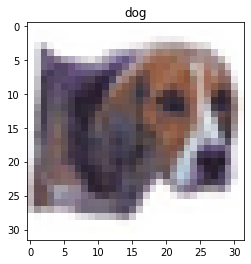

dog


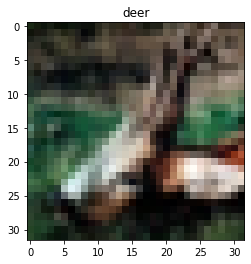

deer


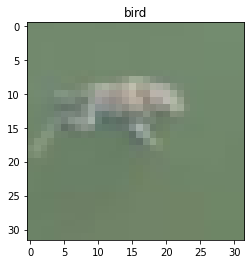

bird


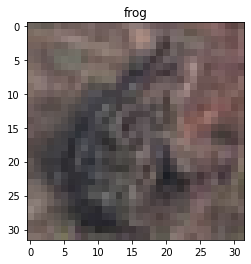

frog


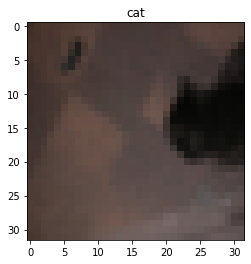

cat


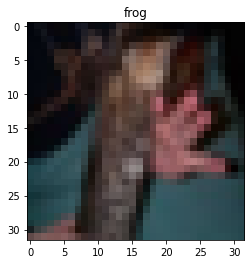

frog


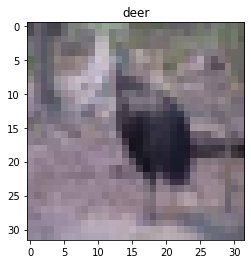

deer


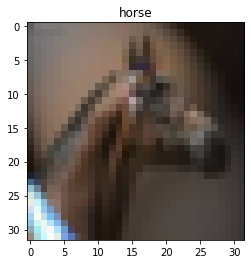

horse


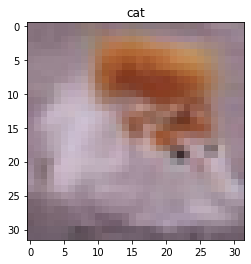

cat


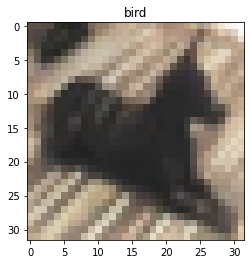

bird


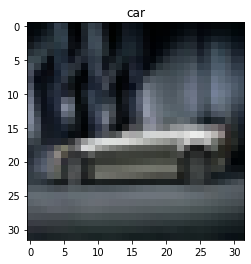

car


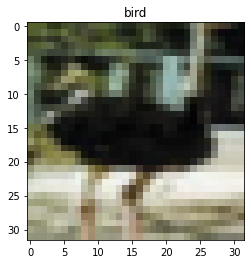

bird


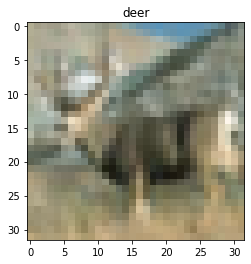

deer


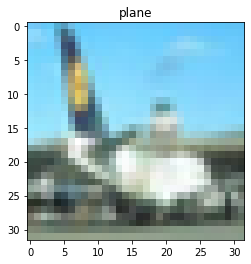

plane


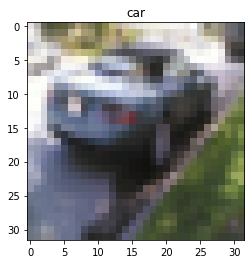

car


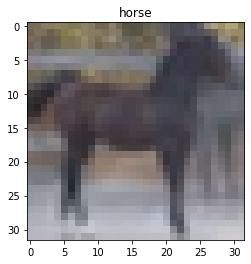

horse


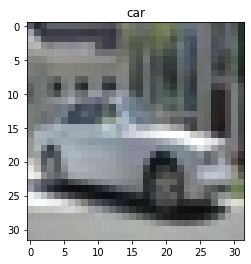

car


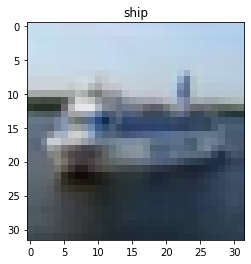

ship


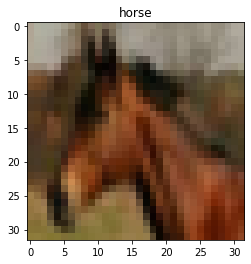

horse


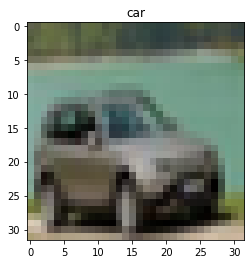

car


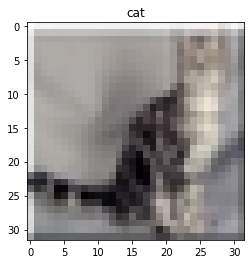

cat


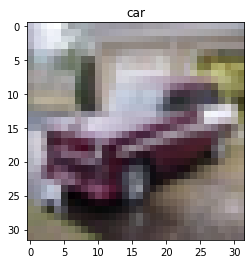

car


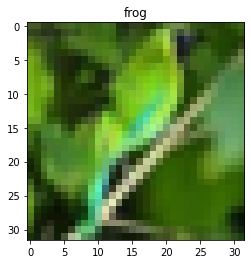

frog


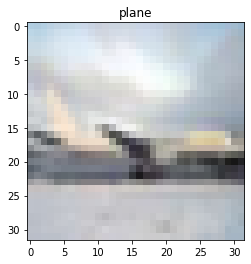

plane


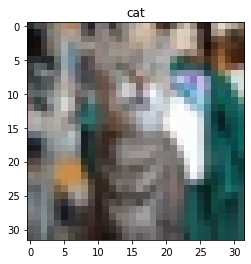

cat


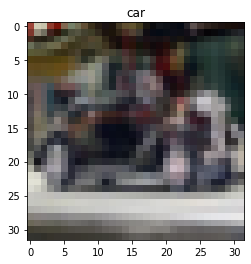

car


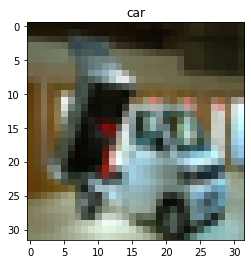

car


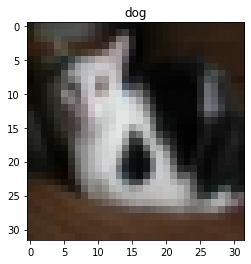

dog


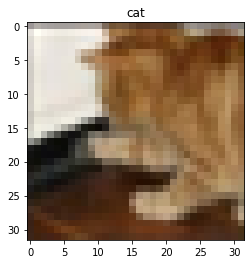

cat


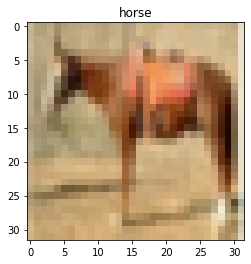

horse


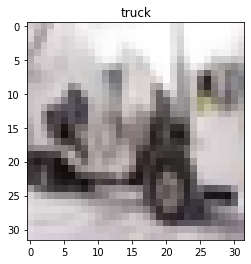

truck


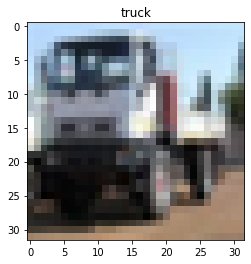

truck


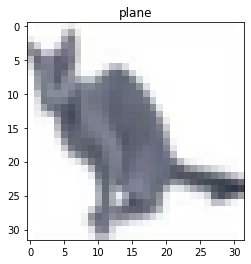

plane


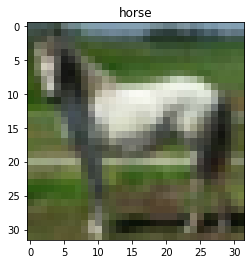

horse


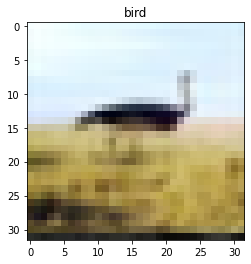

bird


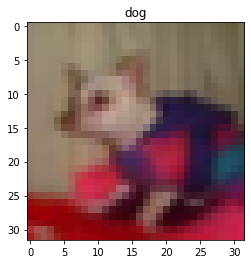

dog


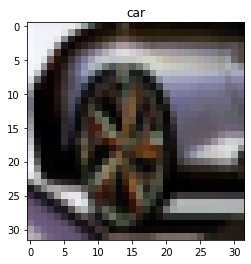

car


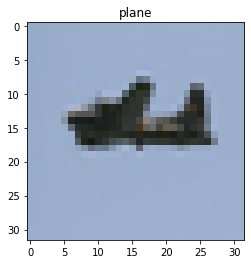

plane


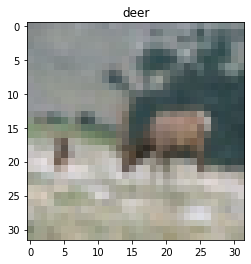

deer


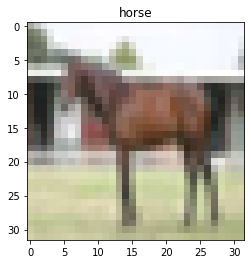

horse


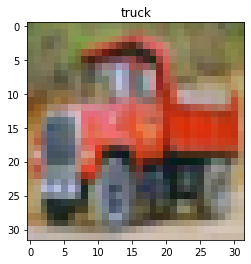

truck


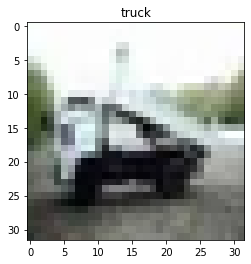

truck


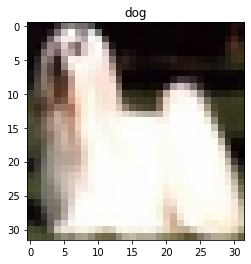

dog


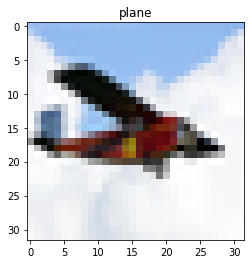

plane


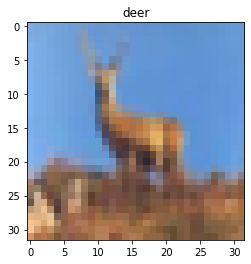

deer


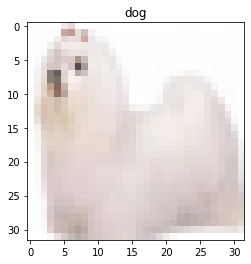

dog


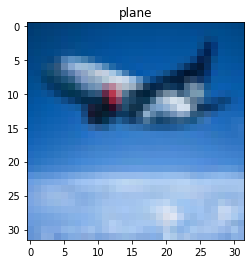

plane


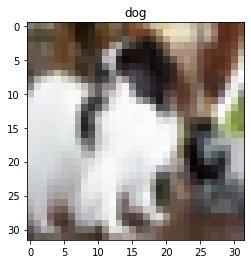

dog


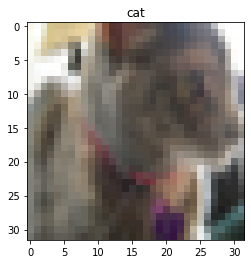

cat


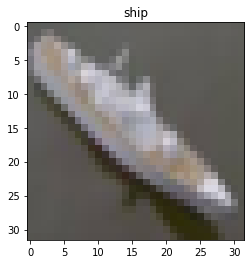

ship


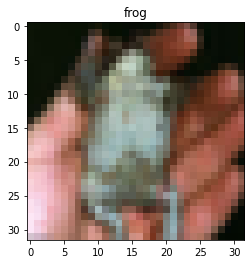

frog


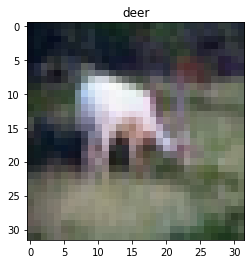

deer


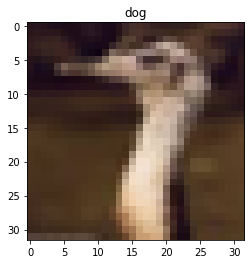

dog


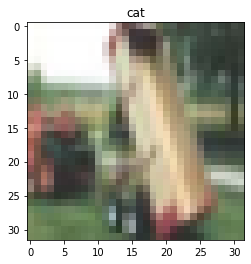

cat


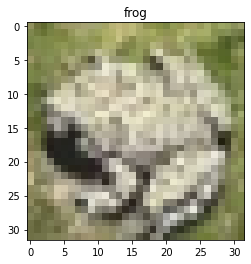

frog


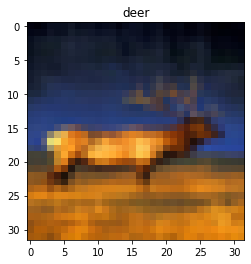

deer


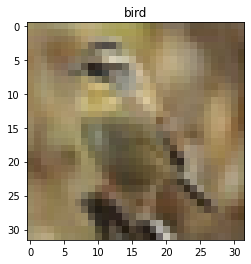

bird


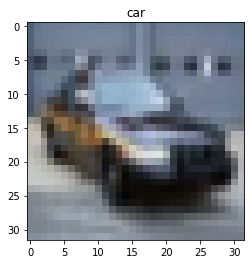

car


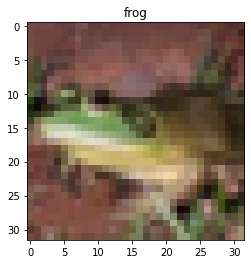

frog


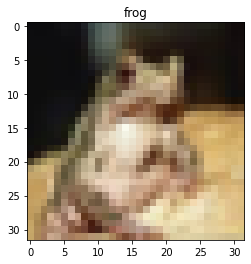

frog


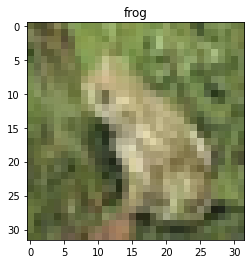

frog


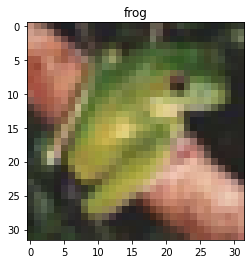

frog


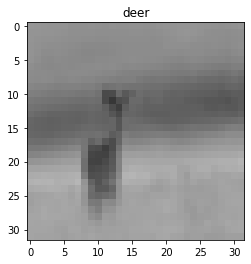

deer


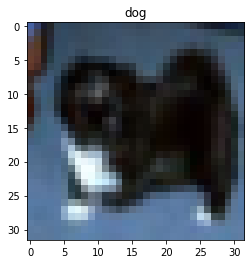

dog


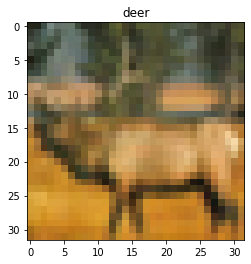

deer


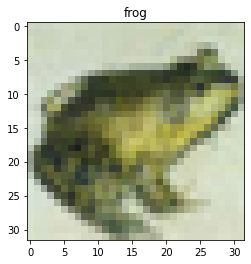

frog


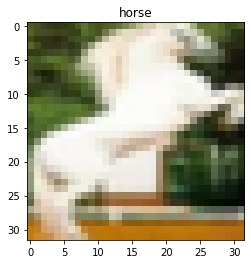

horse


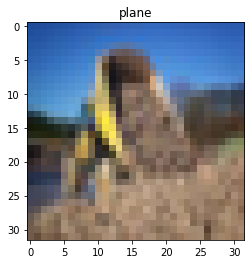

plane


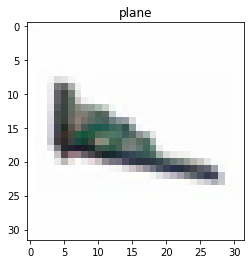

plane


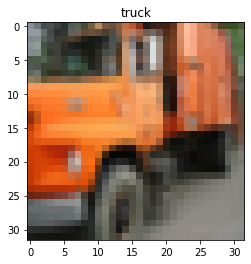

truck


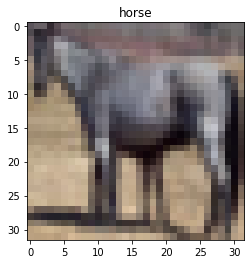

horse


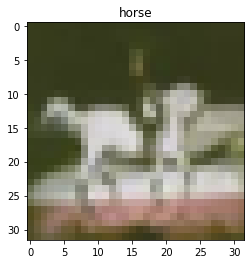

horse


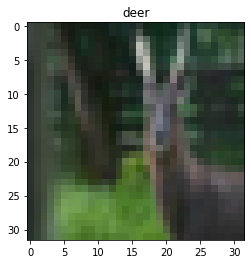

deer


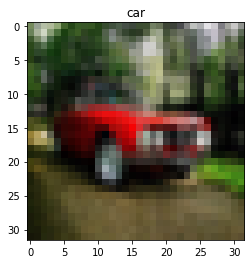

car


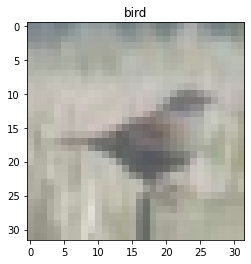

bird


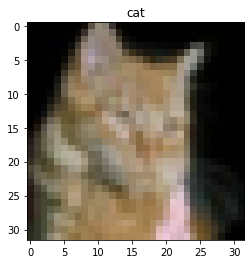

cat


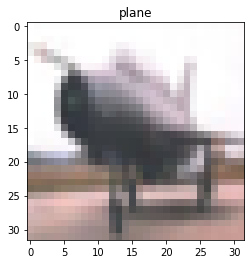

plane


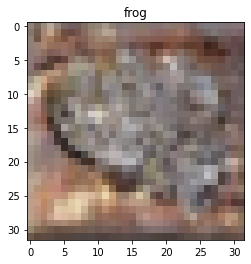

frog


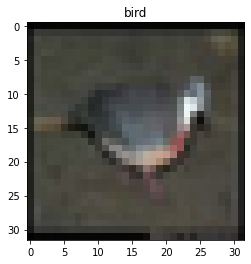

bird


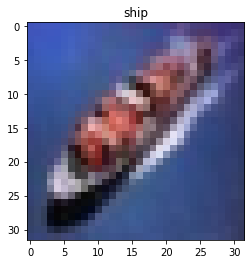

ship


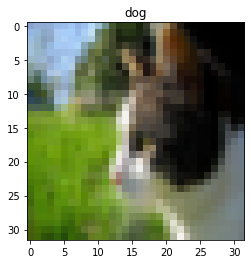

dog


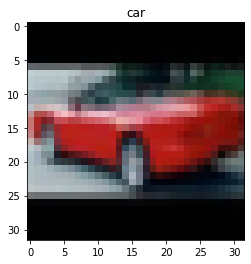

car


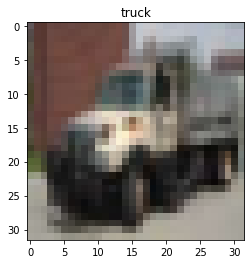

truck


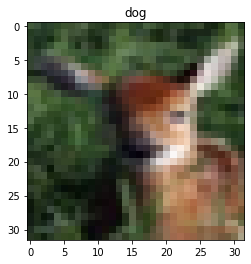

dog


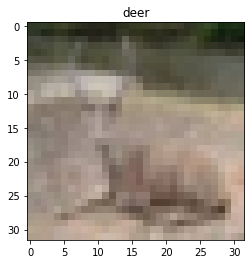

deer


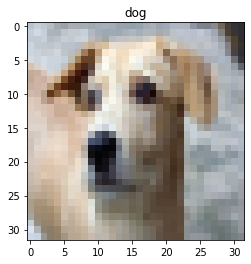

dog


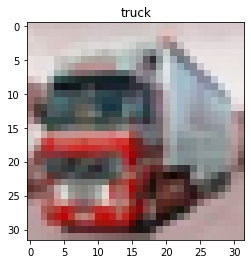

truck


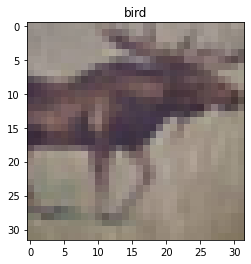

bird


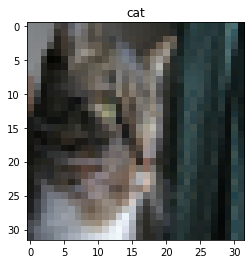

cat


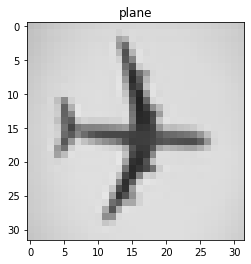

plane


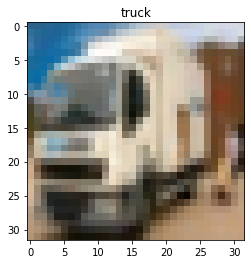

truck


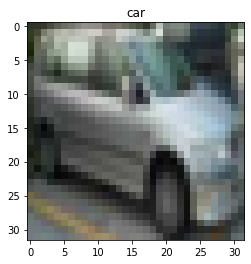

car


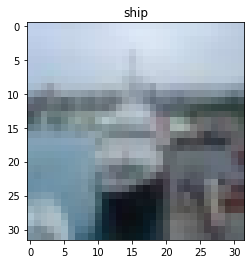

ship


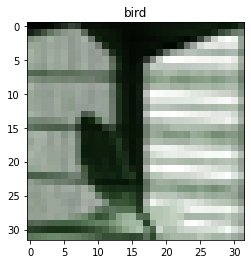

bird


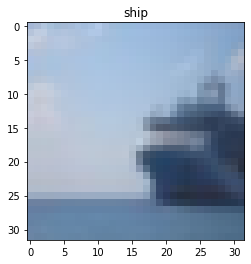

ship


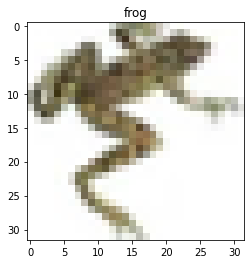

frog


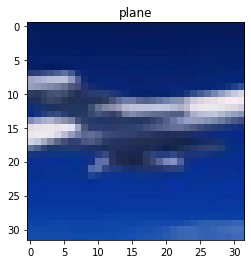

plane


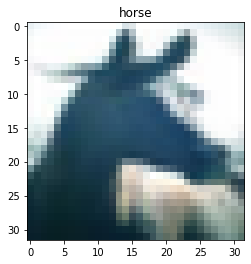

horse


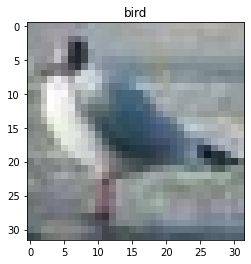

bird


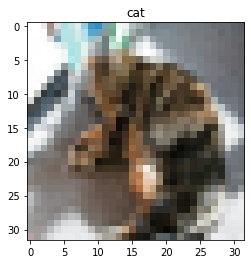

cat


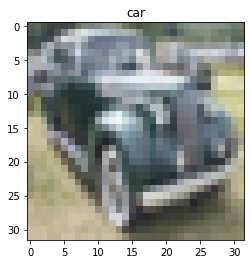

car


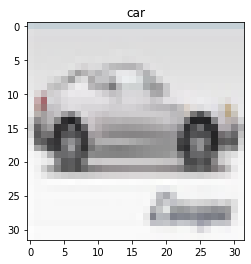

car


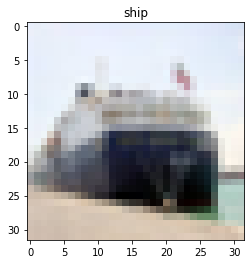

ship


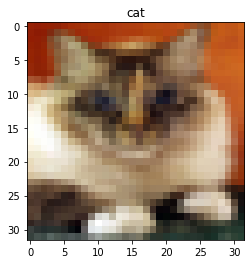

cat


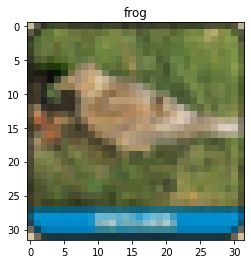

frog


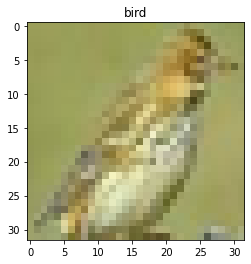

bird


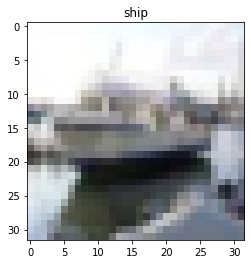

ship


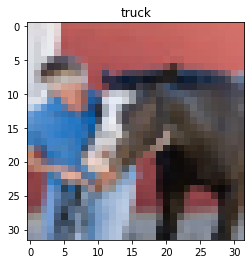

truck


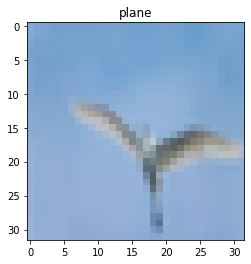

plane


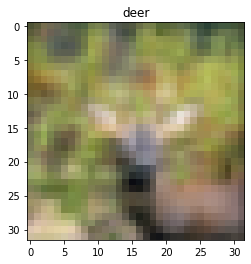

deer


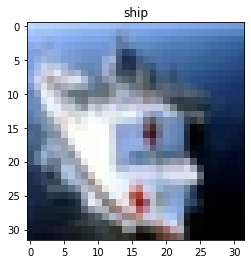

ship


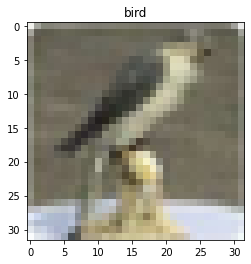

bird


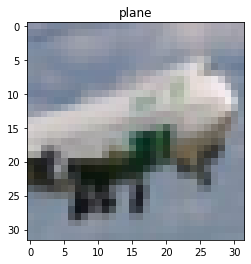

plane


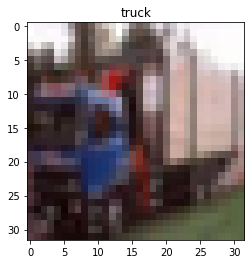

truck


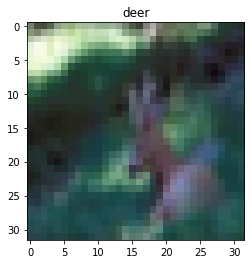

deer


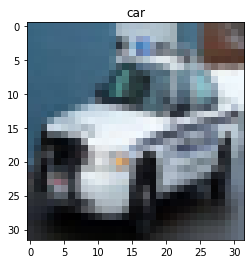

car


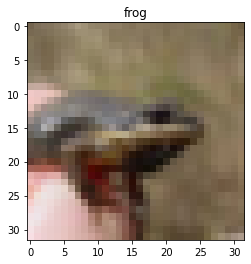

frog


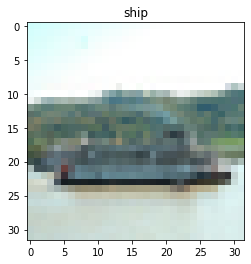

ship


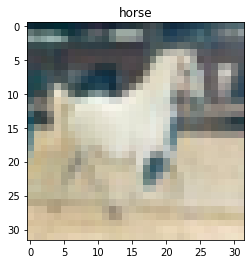

horse


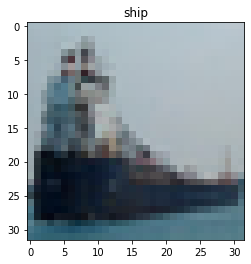

ship


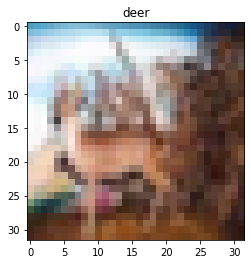

deer


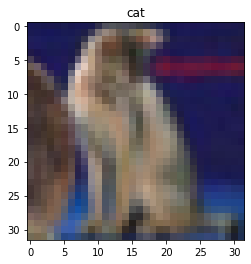

cat


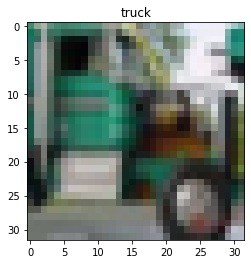

truck


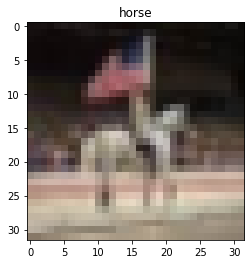

horse


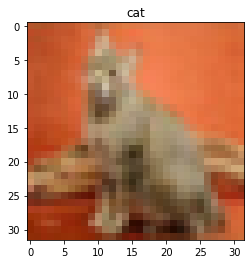

cat


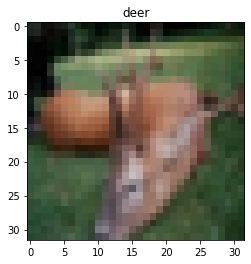

deer


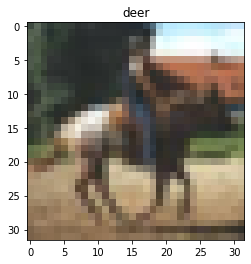

deer


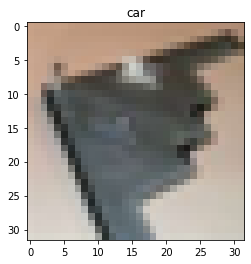

car


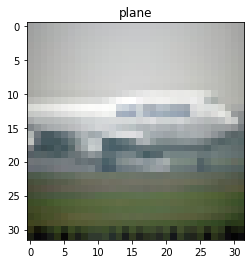

plane


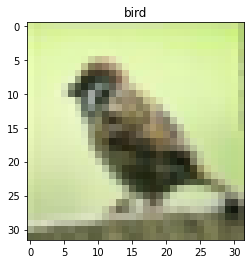

bird


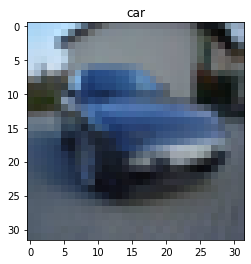

car


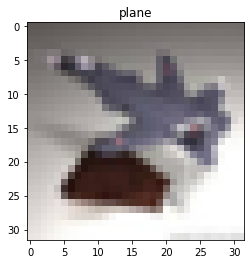

plane


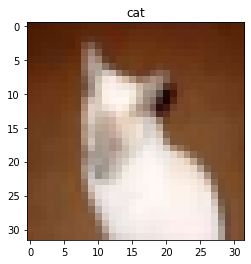

cat


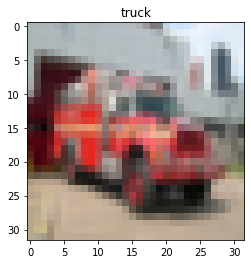

truck


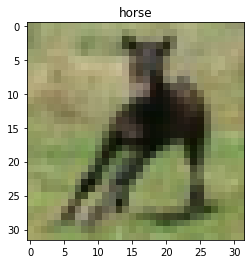

horse


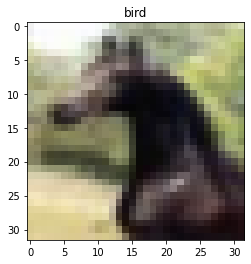

bird


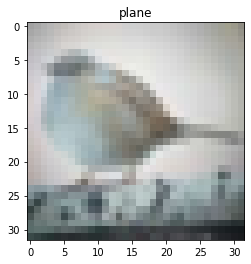

plane


KeyboardInterrupt: ignored

In [16]:
import torch
import torchvision
import matplotlib.pyplot as plt

def classify_image(model, image):
    # Add batch dimension
    image = image.unsqueeze(0)
    # Send image to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)
    # Apply the model to the image
    outputs = model(image)
    # Get the predicted class label
    _, predicted = torch.max(outputs.data, 1)
    # Map the class label index to the corresponding class name
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    class_name = classes[predicted.item()]
    # Display the image and predicted class name
    image = image.cpu().squeeze().permute(1, 2, 0)
    plt.imshow(image)
    plt.title(class_name)
    plt.show()
    return class_name

for batch in cifar10_loader_train:
    images, masks = batch
    class_name = classify_image(model_cifar10, images[0])
    print(class_name)
